In [1]:
using ModelingToolkit, DifferentialEquations, Random, Distributions, Plots, CSV, OrdinaryDiffEq, StatsPlots, Turing, DataFrames
using BenchmarkTools
#using Random; Random.seed!(2)

include("Functions.jl")

flux_vec_eq (generic function with 1 method)

In [2]:
@parameters C_ATP C_ADP C_cit C_AMP C_PFKM C_AMPK C_Pi C_G6P C_GAP C_DHAP # Concentrations 
@parameters L_PFKM L_PFK2 # L values
@parameters Vm_GPI Vm_PFK2 Vm_FBP Vm_ALD # V values. Vf are Vmax forward and Vr are Vmax reversed for each enzyme.
@parameters Keq_GPI Keq_PFKM Keq_PFK2 Keq_FBP Keq_ALD # K_eq for each enzyme

@parameters Kf_GPI Kr_GPI # For r_GPI
@parameters Ki_ATP Ki_cit Ka_f6p Ka_f16bp Ka_AMP Ka_f26bp # For N_PFKM Ki is inhibitors and Ka is activators
@parameters Kc_PFKM K_f6p K_ATP K_f16bp K_ADP # For r_PFKM
@parameters Kc_AMPK v_P # For psi
@parameters K2_ATP K2_f6p K2_f26bp K2_ADP # For r_PFK2. 2 refers to PFK2
@parameters K_FBP_f26bp K_FBP_f6p K_Pi # For r_FBP
@parameters KAld_f16bp K_GAP K_DHAP # For r_ALD

@variables t f6p(t) f16bp(t) f26bp(t)
D = Differential(t)

r_GPI = (Vm_GPI/Kf_GPI)*(C_G6P-(f6p/Keq_GPI))/
    (1 + C_G6P/Kf_GPI + f6p/Kr_GPI)
    
N_PFKM = 1 + L_PFKM*(1 + C_ATP/Ki_ATP)^4*(1 + C_cit/Ki_cit)^4/
    ((1 + f6p/Ka_f6p + f16bp/Ka_f16bp)^4 * (1 + C_AMP/Ka_AMP)^4 * (1 + f26bp/Ka_f26bp)^4)

r_PFKM = ((C_PFKM*(Kc_PFKM/(K_f6p*K_ATP))*(C_ATP*f6p - C_ADP*f16bp/Keq_PFKM))/
    ((1 + f6p/K_f6p)*(1 + C_ATP/K_ATP) + (1 + f16bp/K_f16bp)*(1 + C_ADP/K_ADP) -1))*
    (1/N_PFKM)

psi = (Kc_AMPK*C_AMPK)/((Kc_AMPK*C_AMPK)+v_P)
N_PFK2 = 1 + L_PFK2*(psi/(1-psi))^2

r_PFK2 = (Vm_PFK2/(K2_ATP*K2_f6p))*((C_ATP*f6p)-(C_ADP*f26bp)/Keq_PFK2)/
    ((1+f6p/K2_f6p)*(1+C_ATP/K2_ATP) + (1+f26bp/K2_f26bp)*(1+C_ADP/K2_ADP) -1) *
    (1-(1/N_PFK2))

r_FBP = (Vm_FBP/(K_FBP_f26bp))*(f26bp-(f6p*C_Pi)/Keq_FBP)/
    ((1+f26bp/K_FBP_f26bp) + (1+f6p/K_FBP_f6p)*(1+C_Pi/K_Pi)-1) * 
    (1/N_PFK2)

r_ALD = (Vm_ALD/KAld_f16bp)*(f16bp-(C_GAP*C_DHAP)/Keq_ALD)/
    ((1 + f6p/KAld_f16bp) + (1 + C_GAP/K_GAP)*(1 + C_DHAP/K_DHAP) -1)

eqs = [D(f6p) ~ r_GPI - r_PFKM - r_PFK2 + r_FBP,
    D(f16bp) ~ r_PFKM - r_ALD,
    D(f26bp) ~ r_PFK2 - r_FBP]

@named sys = ODESystem(eqs, t)

sys=structural_simplify(sys)

Model sys with 3 equations
Unknowns (3):
  f6p(t)
  f16bp(t)
  f26bp(t)
Parameters (46):
  K_f16bp
  Ka_f6p
  K_FBP_f6p
  K_FBP_f26bp
⋮
Incidence matrix:3×6 SparseArrays.SparseMatrixCSC{Num, Int64} with 11 stored entries:
 ×  ×  ×  ×  ⋅  ⋅
 ×  ×  ×  ⋅  ×  ⋅
 ×  ⋅  ×  ⋅  ⋅  ×

In [23]:
1.257/0.284

4.426056338028169

In [26]:
1.257/4

0.31425

In [52]:
u0 = [f6p => 1*10^-3,
    f16bp => 1*10^-3,
    f26bp => 1*10^-3]

V = [Vm_GPI => 4.8*10^4,
    Vm_PFK2 => 41.6,
    Vm_FBP => 11.78, 
    Vm_ALD => 6.75*10^2]

C_ATP01 = 1.257
ratio = 4.43
C_ADP01 = C_ATP01/ratio
Cons = [C_ATP => exp(C_ATP01), #M to mM
    #C_ADP => exp(0.284), 
    C_ADP => exp(C_ADP01),
    C_cit => exp(2.97*1.1),
    C_AMP => exp(-5.251),
    C_PFKM => 4*10^-5,
    C_AMPK => 5.7875*10^-1, #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
    C_Pi => 1,
    C_G6P => exp(-0.862),
    C_GAP => exp(-8.159), # No data
    C_DHAP => exp(-6.159)]

L = [L_PFKM => 2*10^9,
    L_PFK2 => 1*10^-3]

Keq = [Keq_GPI =>  0.492,
    Keq_PFKM => 1.96675 *10^3,
    Keq_PFK2 => 16.0,
    Keq_FBP => 56.4458,
    Keq_ALD => 0.0173]

K = [Kf_GPI => 0.3,
    Kr_GPI => 0.123, #0.123
    Ki_ATP => 0.1,
    Ki_cit => 0.1, #
    Ka_f6p => 6*10^-2,
    Ka_f16bp => 0.35, #0.35 for PFKM and 0.65 for PFKL
    Ka_AMP => 0.3,
    Ka_f26bp => 5.5*10^-8, # 5.5*10^-3
    Kc_PFKM => 15.5*10^2/(4*10^-5), # Changed from 15.5*10^2/4*10^-5
    K_f6p => 6*10^-2,
    K_ATP => 6.8*10^-2,
    K_f16bp => 0.65,
    K_ADP => 0.54,
    Kc_AMPK => 0.1, # Check this
    v_P => 0.005, # Check this
    K2_ATP => 0.15,
    K2_f6p => 0.032,
    K2_f26bp => 0.008,
    K2_ADP => 0.062,
    K_FBP_f26bp => 1*10^-3,
    K_FBP_f6p => 25*10^-3,
    K_Pi => 0.23, #
    KAld_f16bp => 5*10^-2,
    K_GAP => 0.189,
    K_DHAP => 3.5*10^-2] 

p= [Cons 
    L 
    V 
    Keq
    K]
print("ATP =", C_ATP01, " ADP =", C_ADP01)

ATP =1.257 ADP =0.2837471783295711

[0.20039077406181569, 0.2235724531262163, 0.022228409890135473]

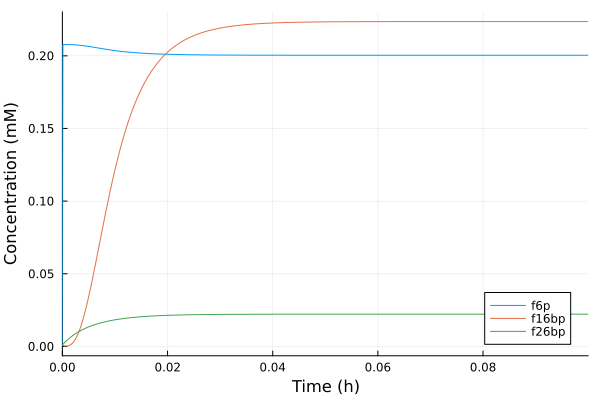

In [53]:
tspan = (0.0, 0.1)
prob = ODEProblem(sys, u0, tspan, p, jac = true)

sol = solve(prob, Rodas4());

print(sol[end])

plot(sol,
    #xlim = (),
    xlabel = "Time (h)",
    ylabel = "Concentration (mM)")

# [0.19655410293899558, 0.3371067717195151, 0.02176338663926538]
# [0.19491011111310236, 0.3852112385986947, 0.017387468161603487] with C_ATP*0.5
# [0.19655339573418162, 0.33712753582532284, 0.021764843973233028] C_ATP01 = 1.257 and ratio = 4.43
# [0.1977135574189757, 0.30298280275773964, 0.019775359933050924] C_ATP01 = 1.257 and ratio = 2
# [0.2008671722281887, 0.20935229435015623, 0.01626966209112268] C_ATP01 = 1.257 and ratio = 1
# [0.20777975869435844, 3.529236215944601e-5, 0.0036306586523936397] C_ATP01 = 1.257 and ratio = 0.1

In [44]:
flux_vec_eq(sol[end], p)

1-element Vector{DataFrame}:
 11×2 DataFrame
 Row │ a           values       
     │ String      Float64      
─────┼──────────────────────────
   1 │ r_GPI       556.327
   2 │ r_PFKM      556.327
   3 │ r_PFK2        2.0445
   4 │ r_FBP         2.0445
   5 │ r_ALD       556.327
   6 │ f6p_flux     -7.63489e-8
   7 │ f16bp_flux    2.51167e-6
   8 │ f26bp_flux    7.23416e-8
   9 │ psi           0.920477
  10 │ N_PFK2        1.13398
  11 │ N_PFKM        2.02458